<a href="https://colab.research.google.com/github/ghlim40/BT/blob/main/my_python_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#라이브러리 설치

In [3]:
!pip install pyupbit
!pip install datetime
!pip install numpy
!pip install pyjwt
!pip install datetime
!pip install schedule
!pip install Prophet

     |████████████████████████████████| 103 kB 8.4 MB/s 
     |████████████████████████████████| 60 kB 3.4 MB/s 
     |████████████████████████████████| 251 kB 10.9 MB/s 
     |████████████████████████████████| 65 kB 2.5 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
  Created wheel for Prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639680 sha256=c9625ce365f58970f5ee36f71e6e548db7442df9d6fb3a07bfc2699239dc3cfa
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built Prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy

In [4]:
#라이브러리 임포트

In [5]:
import pyupbit
import datetime
import time, calendar
import numpy as np
import datetime
import schedule
from fbprophet import Prophet

In [6]:
# set variables
coin = "KRW-BTC"   # 매매를 진행할 가상화폐의 ticker
fees = 0.0005      # 수수료

In [7]:
#access key & secret key

In [8]:
access = "your-access"
secret = "your-secret"

In [9]:
#목표 가격 측정

In [10]:
# -1은 오늘, -2는 어제데이터
def get_targetPrice(df, K) :
    range = df['high'][-2] - df['low'][-2] #전일 고가와 전일 저가의 차이값
    return df['open'][-1] + range * K #당일 시가 + range값에 상수k를 곱하여 더함

In [11]:
#코인 구매기능

In [12]:
def buy_all(coin) :
    #get_balance : 보유중인 잔고 조회
    balance = upbit.get_balance("KRW") * 0.9995
    
    #업비트 최소 주문금액이 5000원 이상
    if balance >= 5000 : 
        print(upbit.buy_market_order(coin, balance))

In [13]:
#코인 판매기능

In [14]:
def sell_all(coin) :
    balance = upbit.get_balance(coin)
    price = pyupbit.get_current_price(coin)
    
    #업비트 최소 주문금액이 5000원 이상
    if price * balance >= 5000 : 
        print(upbit.sell_market_order(coin, balance))


In [15]:
#누적수익률 반환

In [16]:
# drr = Daily Rate Of Return 하루수익률
# crr = Cumulative Rate Of Return 누적수익률
# mdd = Max Draw Down, dd = Draw Down 손해율

def get_crr(df, fees, K) :
    df['range'] = df['high'].shift(1) - df['low'].shift(1)
    df['targetPrice'] = df['open'] + df['range'] * K
    df['drr'] = np.where(df['high'] > df['targetPrice'], (df['close'] / (1 + fees)) / (df['targetPrice'] * (1 + fees)) , 1)
    return df['drr'].cumprod()[-2]

In [17]:
#해당 일자의 가장 적절한 K값 선정

In [18]:
def get_best_K(coin, fees) :
    df = pyupbit.get_ohlcv(coin, interval = "day", count = 21)
    max_crr = 0
    best_K = 0.5
    for k in np.arange(0.0, 1.0, 0.1) :
        crr = get_crr(df, fees, k)
        if crr > max_crr :
            max_crr = crr
            best_K = k
    return best_K

In [19]:
#미래가 예측

In [20]:
df_predict = pyupbit.get_ohlcv(coin, interval="minute60")
df_predict

df_predict = df_predict.reset_index()
df_predict['ds'] = df_predict['index']
df_predict['y'] = df_predict['close']
data_predict = df_predict[['ds','y']]
data_predict

,ds,y
0,2022-01-04 06:00:00,56276000.0
1,2022-01-04 07:00:00,56410000.0
2,2022-01-04 08:00:00,56641000.0
3,2022-01-04 09:00:00,56430000.0
4,2022-01-04 10:00:00,56132000.0
...,...,...
195,2022-01-12 09:00:00,52057000.0
196,2022-01-12 10:00:00,52007000.0
197,2022-01-12 11:00:00,51847000.0
198,2022-01-12 12:00:00,51821000.0


In [21]:
#학습

In [22]:
model = Prophet()
model.fit(data_predict)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [23]:
#24시간 미래 예측
future = model.make_future_dataframe(periods=24, freq='H')
forecast = model.predict(future)

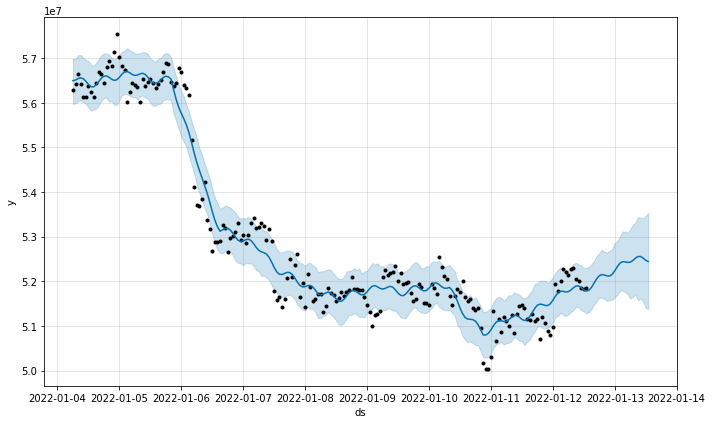

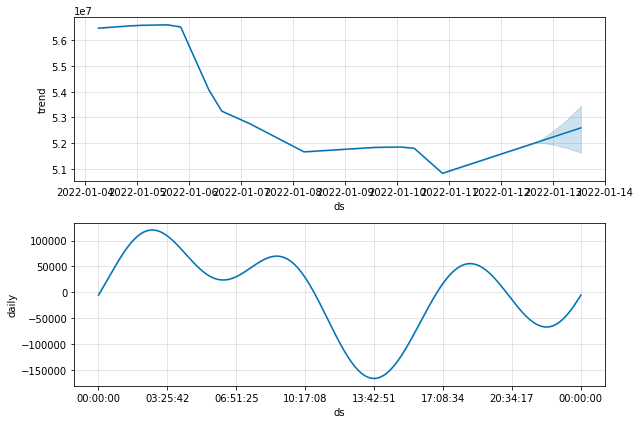

In [24]:
#그래프1
fig1 = model.plot(forecast)
#그래프2
fig2 = model.plot_components(forecast)

In [25]:
#매수 시점의 가격
nowValue = pyupbit.get_current_price(coin)
nowValue

#종가의 가격을 구함

#현재 시간이 자정 이전
closeDf = forecast[forecast['ds'] == forecast.iloc[-1]['ds'].replace(hour=9)]

#현재 시간이 자정 이후
if len(closeDf) == 0:
  closeDf = forecast[forecast['ds'] == data_predict.iloc[-1]['ds'].replace(hour=9)]

#어쨋든 당일 종가
closeValue = closeDf['yhat'].values[0]

In [26]:
#구체적인 가격
print("현재 시점 가격: ", nowValue)
print("종가의 가격: ", closeValue)
forecast

현재 시점 가격:  51856000.0
종가의 가격:  52555331.07268986


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-04 06:00:00,5.646979e+07,5.597263e+07,5.699344e+07,5.646979e+07,5.646979e+07,24623.843643,24623.843643,24623.843643,24623.843643,24623.843643,24623.843643,0.0,0.0,0.0,5.649441e+07
1,2022-01-04 07:00:00,5.647608e+07,5.598720e+07,5.697268e+07,5.647608e+07,5.647608e+07,33234.037989,33234.037989,33234.037989,33234.037989,33234.037989,33234.037989,0.0,0.0,0.0,5.650931e+07
2,2022-01-04 08:00:00,5.648237e+07,5.603692e+07,5.707027e+07,5.648237e+07,5.648237e+07,58325.818799,58325.818799,58325.818799,58325.818799,58325.818799,58325.818799,0.0,0.0,0.0,5.654069e+07
3,2022-01-04 09:00:00,5.648866e+07,5.605135e+07,5.706751e+07,5.648866e+07,5.648866e+07,69651.306310,69651.306310,69651.306310,69651.306310,69651.306310,69651.306310,0.0,0.0,0.0,5.655831e+07
4,2022-01-04 10:00:00,5.649495e+07,5.601565e+07,5.700840e+07,5.649495e+07,5.649495e+07,43461.843764,43461.843764,43461.843764,43461.843764,43461.843764,43461.843764,0.0,0.0,0.0,5.653841e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,2022-01-13 09:00:00,5.248568e+07,5.157206e+07,5.343609e+07,5.174233e+07,5.311323e+07,69651.306311,69651.306311,69651.306311,69651.306311,69651.306311,69651.306311,0.0,0.0,0.0,5.255533e+07
220,2022-01-13 10:00:00,5.251321e+07,5.161817e+07,5.342742e+07,5.171928e+07,5.319890e+07,43461.843765,43461.843765,43461.843765,43461.843765,43461.843765,43461.843765,0.0,0.0,0.0,5.255668e+07
221,2022-01-13 11:00:00,5.254075e+07,5.154718e+07,5.341460e+07,5.168935e+07,5.328195e+07,-20289.416161,-20289.416161,-20289.416161,-20289.416161,-20289.416161,-20289.416161,0.0,0.0,0.0,5.252046e+07
222,2022-01-13 12:00:00,5.256828e+07,5.140464e+07,5.346262e+07,5.166485e+07,5.334771e+07,-97197.258244,-97197.258244,-97197.258244,-97197.258244,-97197.258244,-97197.258244,0.0,0.0,0.0,5.247109e+07


In [27]:
#거래 전략

In [28]:
if __name__ == '__main__': 
    try:
        upbit = pyupbit.Upbit(access, secret)

        K = 0.5            # targetPrice 를 구할 때 사용할 K 값
    
        start_balance = upbit.get_balance("KRW")
        df = pyupbit.get_ohlcv(coin, count = 2, interval = "day")
        targetPrice = get_targetPrice(df, get_best_K(coin, fees))
        print(datetime.datetime.now().strftime('%y/%m/%d %H:%M:%S'), "\t\tBalance :", start_balance, "KRW \t\tYield :", ((start_balance / start_balance) - 1) * 100, "% \t\tNew targetPrice :", targetPrice, "KRW")

        while True :
            now = datetime.datetime.now()
            if now.hour == 9 and now.minute == 0 and now.second == 0:    # when am 09:02:00
                sell_all(coin)
                df = pyupbit.get_ohlcv(coin, count = 2, interval = "day")
                targetPrice = get_targetPrice(df, get_best_K(coin, fees))
                time.sleep(1)

                cur_balance = upbit.get_balance("KRW")
                print(now.strftime('%y/%m/%d %H:%M:%S'), "\t\tBalance :", cur_balance, "KRW \t\tYield :", ((cur_balance / start_balance) - 1) * 100, "% \t\tNew targetPrice :", targetPrice, "KRW")
            
            elif targetPrice <= pyupbit.get_current_price(coin) :
                buy_all(coin)
                start_time = df.index[-1]
                end_time = start_time + datetime.timedelta(days=1)
                if end_time > now :
                    print((end_time - now).seconds)
                    time.sleep((end_time - now).seconds - 60)
    
            time.sleep(1)

    except Exception as e:
        print(e)
        time.sleep(1)


401
잘못된 엑세스 키입니다.
invalid_access_key
InValidAccessKey
unsupported operand type(s) for /: 'NoneType' and 'NoneType'
